In [1]:
# import CartPole.py from local directory
import CartPole, sf3utility
import matplotlib.collections
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate
import random

plt.rcParams["font.family"] = "Georgia"
#plt.rcParams['figure.figsize'] = [9.0, 7.0]
#plt.rcParams['figure.dpi'] = 400

# store results for later
cache = {}

In [2]:
# allows nice plots that can be redrawn
%matplotlib notebook

# Task 1.1 - Simulation of Rollout

I established a few different initial conditions and then plotted graphs to represent the resulting motions. I recorded the values of the state vector as the system evolved and then plotted some of the elements of the vector against each other at each timestep to form a curve.

In [3]:
# instantiate a cartpole and use a small timestep to get smooth lines
rollout_cartpole = CartPole.CartPole()

rollout_cartpole.sim_steps = 1
rollout_cartpole.delta_time = 0.01

## Small Oscillation about Stable Equilibirum

<IPython.core.display.Javascript object>


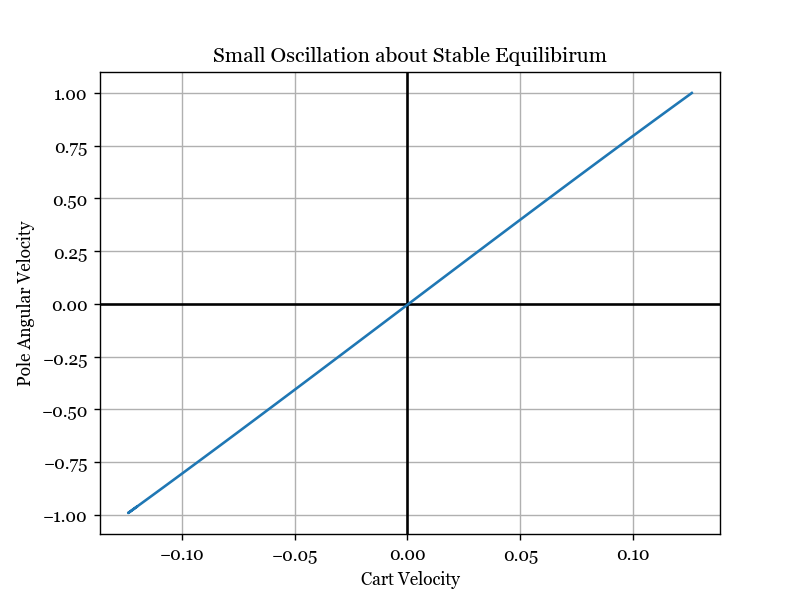

In [4]:
# small oscillations about stable equilibrium

rollout_cartpole.reset()

rollout_cartpole.cart_velocity = 0.126
rollout_cartpole.pole_angvel = 1

x, y = [], []
states = []

for i in range(50):
    
    rollout_cartpole.perform_action()
    
    x.append( rollout_cartpole.cart_velocity )
    y.append( rollout_cartpole.pole_angvel )
    
    states.append( rollout_cartpole.get_state() )
    
    
fig, ax = plt.subplots(1, 1, num=2)
sf3utility.setup_phase_portrait( ax )
ax.plot( x, y )

ax.set_title( "Small Oscillation about Stable Equilibirum" )
ax.set_xlabel( "Cart Velocity" )
ax.set_ylabel( "Pole Angular Velocity" )

states = np.array( states )
cache["states_small_oscillations"] = states

The plot above shows pole angular velocity plotted against cart velocity as time progresses through the rollout - the system oscillates up and down the blue line as the pole swings. The linear trend reflects the small angle assumption - the restoring force from the pendulum is a linear function of the deflection. From linear vibration theory we know the cart and pole vibrate at the same frequency so they "move together" and are therefore linearly correlated.

## Large Amplitude Oscillations

<IPython.core.display.Javascript object>


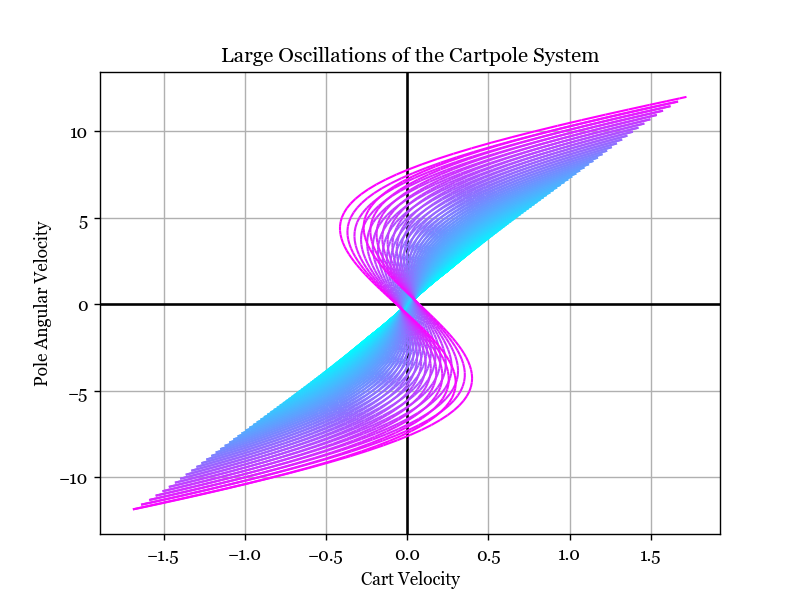

In [5]:
# large oscillations about stable equilibrium

rollout_cartpole.reset()

rollout_cartpole.cart_velocity = 1.72
rollout_cartpole.pole_angvel = 12
rollout_cartpole.mu_p = 0.001 # increase friction to speed up convergence

x, y = [], []
states = []

for i in range(10000):
    
    rollout_cartpole.perform_action()
    
    x.append( rollout_cartpole.cart_velocity )
    y.append( rollout_cartpole.pole_angvel )
    
    states.append( rollout_cartpole.get_state() )
    
    
fig, ax = plt.subplots(1, 1, num=3)
sf3utility.setup_phase_portrait( ax )

ax.set_xlim( min(x) * 1.12, max(x) * 1.12 )
ax.set_ylim( min(y) * 1.12, max(y) * 1.12 )

points   = np.array([x, y]).T.reshape(-1, 1, 2)[::-1]
segments = np.concatenate( [points[:-1], points[1:]], axis=1 )
colouring_array =  np.linspace( 0.0, 1.0, len(x) ) ** 3

linecollection = matplotlib.collections.LineCollection( segments, array=colouring_array, cmap="cool", zorder=3, linewidths=1.2 )

ax.add_collection( linecollection )

ax.set_title( "Large Oscillations of the Cartpole System" )
ax.set_xlabel( "Cart Velocity" )
ax.set_ylabel( "Pole Angular Velocity" )

states = np.array( states )
cache["states_large_oscillations"] = states

The plot above shows large amplitude oscillations, with the line turning from magenta to cyan as time progresses. The small angle approximation no longer holds, with the curve of the lines showing the tendency of the cart to change direction during the pole's swing. The plot shows how the amplitude and curvature of the line decreases as energy is dissapated and we return to the small oscillation regime.

## Swinging Over the Top

<IPython.core.display.Javascript object>


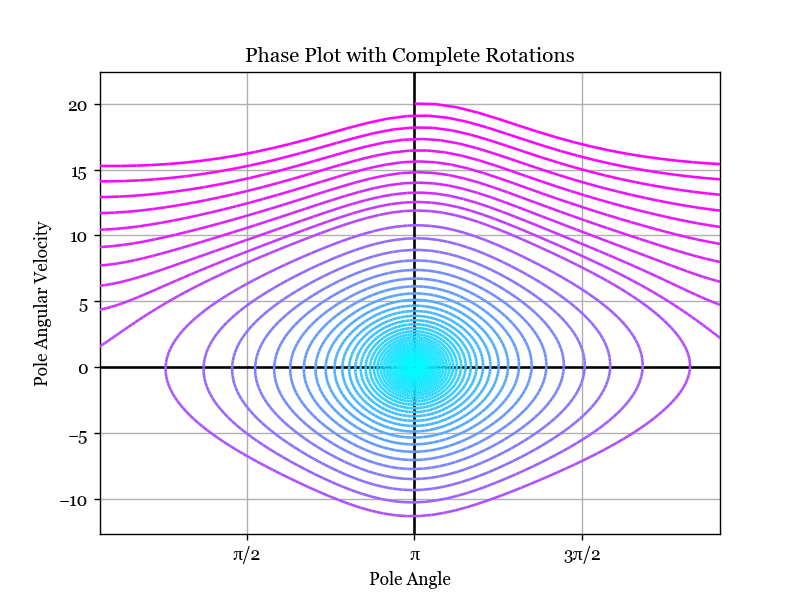

Text(0, 0.5, 'Pole Angular Velocity')

In [6]:
# even larger oscillations

rollout_cartpole.reset()

rollout_cartpole.cart_velocity = 4
rollout_cartpole.pole_angvel = 20
rollout_cartpole.mu_p = 0.005 # increase friction to speed up convergence
    
x, y = [], []

for i in range( 5700 ):
    
    pole_angle = rollout_cartpole.pole_angle % (2*np.pi)
    
    if pole_angle > 6.1:
        x.append( np.nan )
        y.append( np.nan )
        
    else:
        x.append( pole_angle )
        y.append( rollout_cartpole.pole_angvel )
    
    rollout_cartpole.perform_action()
    
    
fig, ax = plt.subplots(1, 1, num=4)
sf3utility.setup_phase_portrait( ax )
ax.axvline( x=np.pi, color="black" )

ax.set_xlim( min(x) * 1.12, max(x) * 1.12 )
ax.set_ylim( min(y) * 1.12, max(y) * 1.12 )

points   = np.array([x, y]).T.reshape(-1, 1, 2)[::-1]
segments = np.concatenate( [points[:-1], points[1:]], axis=1 )
colouring_array =  np.linspace( 0.0, 1.0, len(x) ) ** 3

linecollection = matplotlib.collections.LineCollection( segments, array=colouring_array, cmap="cool", zorder=3 )

ax.add_collection( linecollection )

ax.set_xlim(0.2, 6)
ax.set_xticks( np.pi * np.array([0.5, 1, 1.5]) )
ax.set_xticklabels( ["π/2", "π", "3π/2"] )

ax.set_title( "Phase Plot with Complete Rotations" )
ax.set_xlabel( "Pole Angle" )
ax.set_ylabel( "Pole Angular Velocity" )

The plot above is the phase portrait of the pole angle and angular velocity, again starting from magenta and going to cyan. The upper region is where full rotations of the pole occur; then when enough energy is dissipated the system falls into the lower spiral towards the stable equilibrium at a pole angle of pi.

# Task 1.2: Changes in State

The change in state vector over the next time step $Y\equiv X(T)-X(0)$ is related to the current state vector $X(0) = [x, \dot x, \theta, \dot \theta]$ by some complex function which I want to model. I made some plots showing how the change in state vector depends on the current state vector, noting that the change in state vector is not a function of the cart position due to the translational symmetry/invariance of the system.

It is more helpful to investigate the change in state as a function of the initial state rather than the subsequent state as a function of the current state. This is because the subsequent state will be quite similar (almost linearly related) to the initial state, assuming a small timestep. We can capture more meaning in our model by investigating the change in state, which subtracts off the information we already know (the initial state).

## Effect of Varying Initial Cart Velocity and Pole Angle

In [7]:
# sweep over different initial cart velocities and angles and find the subsequent change in state

# number of steps to vary the intial conditions across their range
Nsteps = 30

# setup some intial conditions to loop over, varying the intial pole angle and cart velocity

initial_cart_positions  = np.array( [1] )
initial_cart_velocities = np.linspace( -10, 10, num=Nsteps )
initial_pole_angles     = np.linspace( -np.pi, np.pi, num=Nsteps )
initial_pole_angvels    = np.array( [0] )

# create array of initial state vectors

initial_states = np.array( np.meshgrid( 
    initial_cart_positions, 
    initial_cart_velocities, 
    initial_pole_angles, 
    initial_pole_angvels 
)).T.squeeze()

# get 2d array of subsquent state vectors

subsequent_states = [ CartPole.perform_action( state ) for state in initial_states.reshape( (Nsteps**2,4) ) ]
subsequent_states = np.array( subsequent_states ).reshape( (Nsteps, Nsteps, 4) )

state_changes = subsequent_states - initial_states

<IPython.core.display.Javascript object>


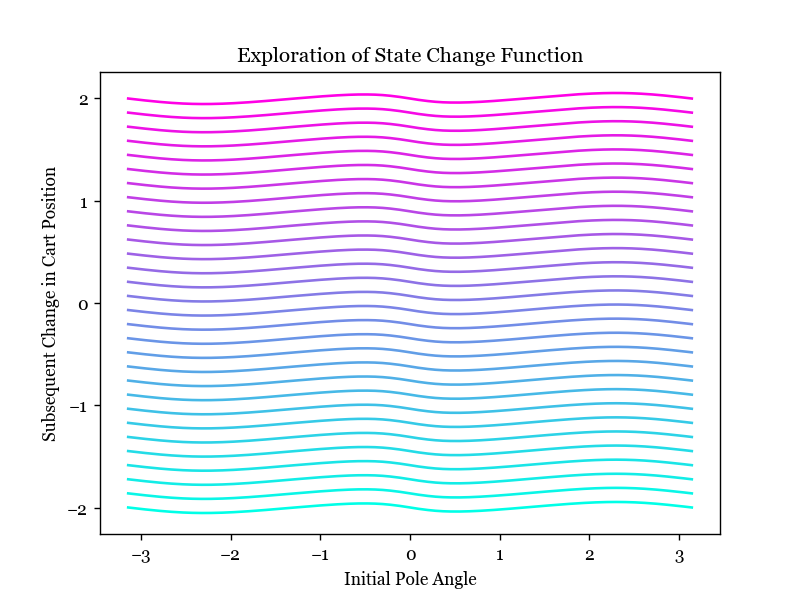

Text(0, 0.5, 'Subsequent Change in Cart Position')

In [8]:
fig, ax = plt.subplots(1, 1, num=5)  

# create array of interpolated colours 

col_lerp = np.linspace(0, 1, Nsteps)[np.newaxis].T
colours = ( 1 - col_lerp ) * np.array( [0, 255, 231, 255] )/255 + col_lerp * np.array( [255, 0, 230, 255] )/255


for i, row in enumerate(state_changes):
       
    # convert to arrays and extract certain components from vectors
    
    x = initial_states[:,i,2] # extract initial angle
    y = state_changes[:,i,0] # extract change in cart position
    
    # code to smooth plot lines
    
    xnew = np.linspace( x.min(), x.max(), 300 ) 

    y_spline = scipy.interpolate.make_interp_spline(x, y, k=2)
    y_smooth = y_spline(xnew)
    
    # plot then move onto next line

    ax.plot( xnew, y_smooth, color=colours[i] ) 

ax.set_title( "Exploration of State Change Function" )
ax.set_xlabel( "Initial Pole Angle" )
ax.set_ylabel( "Subsequent Change in Cart Position" )

In the plot above, I am varying initial pole angle along the lines in the x direction, and varying initial cart velocity between lines, from -10 in cyan to +10 in magenta. The y axis is the change in cart position. We can see that the lines are equally spaced, so the change in cart position seems to be a linear function of cart velocity which makes sense. However, the change in cart position is a (weakly) nonlinear function of the pole angle since there is a slight wobble in the lines.

Plotting the changes in other state variables in this way yields coincident lines which are better represented in a contour plot:

<IPython.core.display.Javascript object>


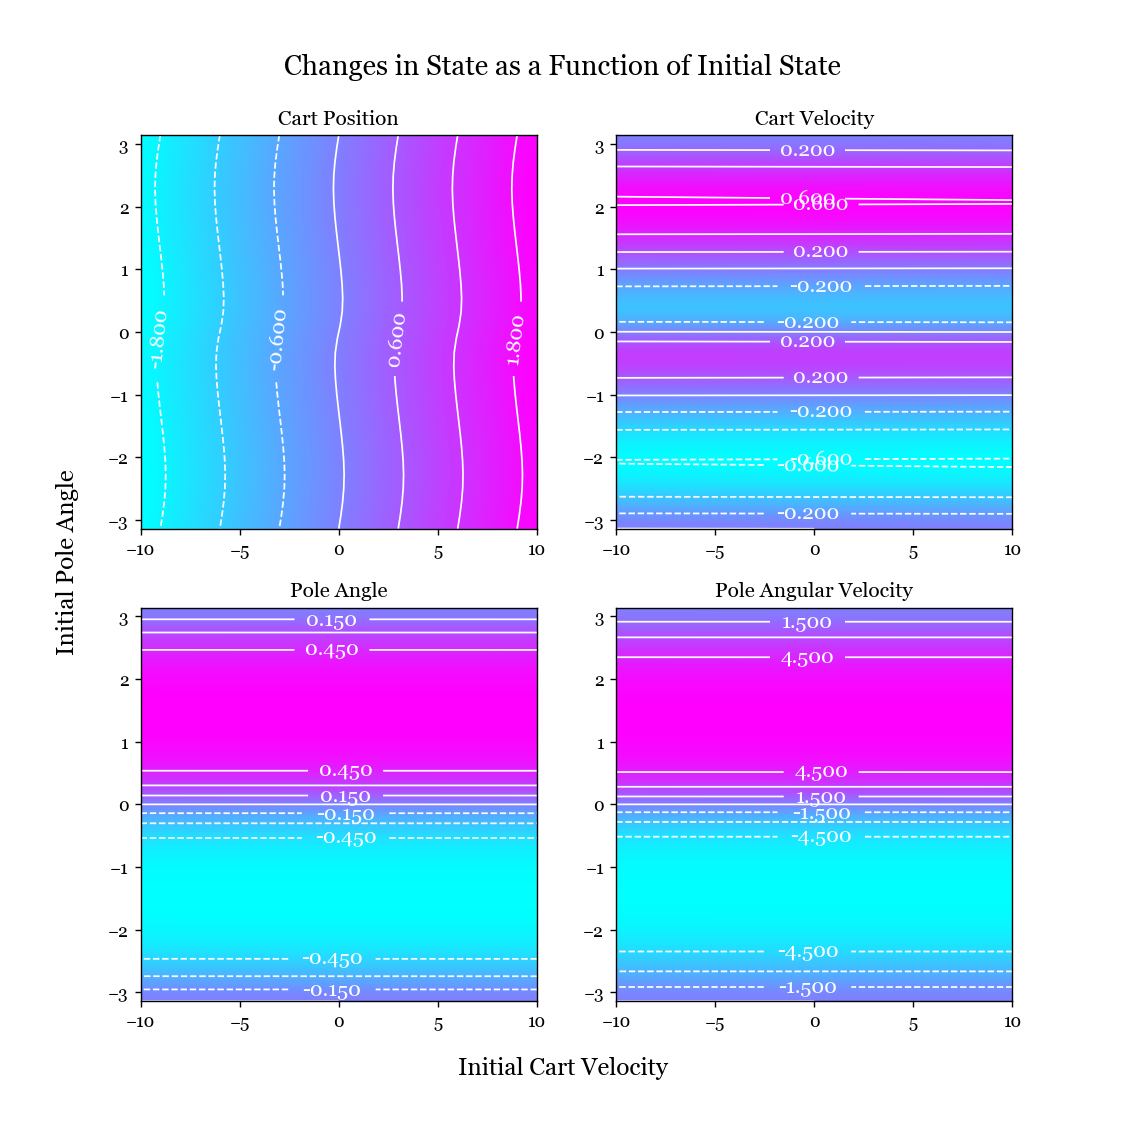

Text(0.06, 0.5, 'Initial Pole Angle')

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, num=6, figsize=(9,9))

titles = ["Cart Position", "Cart Velocity", "Pole Angle", "Pole Angular Velocity"]

for i, ax in enumerate( [ax1, ax2, ax3, ax4] ):

    ax.imshow( state_changes[:,:,i], interpolation="bicubic", extent=(-10, 10, -np.pi, np.pi), aspect='auto', cmap="cool", origin='lower' )
    contour = ax.contour( initial_states[0,:,1], initial_states[:,0,2], state_changes[:,:,i], colors="white", linewidths=1 )
    ax.clabel( contour, contour.levels[1::2], inline=True, fontsize=12 )
    
    ax.set_title( titles[i] )
    
fig.text(0.5, 0.94, 'Changes in State as a Function of Initial State', ha='center', va='center', fontsize=16)
fig.text(0.5, 0.05, 'Initial Cart Velocity', ha='center', va='center', fontsize=14)
fig.text(0.06, 0.5, 'Initial Pole Angle', ha='center', va='center', rotation='vertical', fontsize=14)


In the plot above, the inital cart velocity varies in the x direction and the intial pole angle in the y direction. The subsequent changes in cart position, cart velocity and pole angle are shown as contour plots. The changes in cart velocity, pole angle and pole angular velocity are not functions of the initial cart velocity. This must be the case because any initial cart velocity can be achieved by assuming a different intertial reference frame, leaving the rest of the dynamics unchanged.

The same reasoning leads to the contour plots for varying cart velocity and pole angular velocity having straight lines so I will move to the more interesting combination of varying pole angle and angular velocity.

## Effect of Varying Initial Pole Angle and Angular Velocity

In [10]:
# sweep over different initial pole angles and angvels and find the subsequent change in state

# number of steps to vary the intial conditions across their range
Nsteps = 30

# setup some intial conditions to loop over, varying the intial pole angle and angular velocity

initial_cart_positions  = np.array( [2] )
initial_cart_velocities = np.array( [4] )
initial_pole_angles     = np.linspace( -np.pi, np.pi, num=Nsteps )
initial_pole_angvels    = np.linspace( -15, 15, num=Nsteps )

# create array of initial state vectors

initial_states = np.array( np.meshgrid(
    initial_cart_positions, 
    initial_cart_velocities, 
    initial_pole_angles, 
    initial_pole_angvels 
)).T.squeeze()

# get 2d array of subsquent state vectors

state_changes = [ CartPole.perform_action( state ) - state for state in initial_states.reshape( (Nsteps**2,4) ) ]
state_changes = np.array( state_changes ).reshape( (Nsteps, Nsteps, 4) )

# cache data for later

cache["state_changes_varying_angle_and_angvel"] = state_changes

<IPython.core.display.Javascript object>


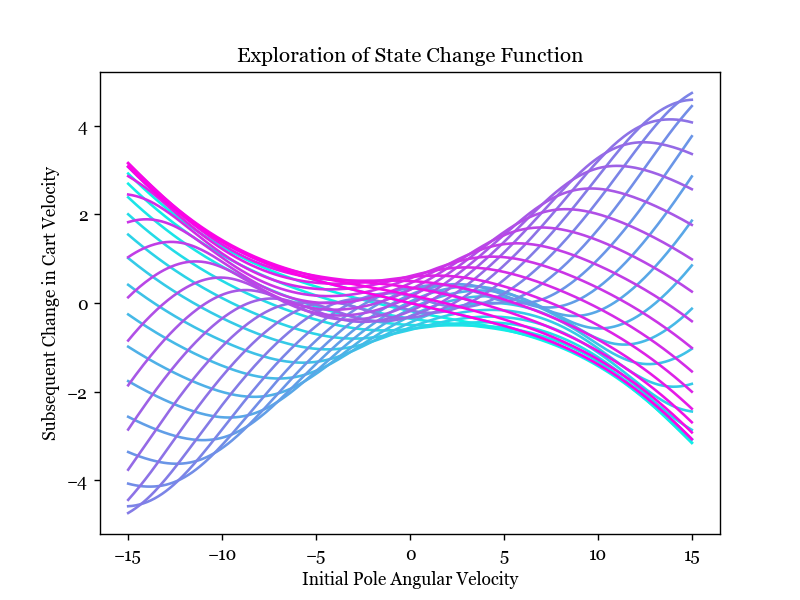

Text(0, 0.5, 'Subsequent Change in Cart Velocity')

In [11]:
fig, ax = plt.subplots(1, 1, num=8)  

# create array of interpolated colours 

col_lerp = np.linspace(0, 1, Nsteps)[np.newaxis].T
colours = ( 1 - col_lerp ) * np.array( [0, 255, 231, 255] )/255 + col_lerp * np.array( [255, 0, 230, 255] )/255


for i, row in enumerate(state_changes):
       
    # convert to arrays and extract certain components from vectors
    
    x = initial_states[:,i,3] # extract initial angular velocity
    y = state_changes[:,i,1] # extract change in cart velocity
    
    # code to smooth plot lines
    
    xnew = np.linspace( x.min(), x.max(), 300 ) 

    y_spline = scipy.interpolate.make_interp_spline(x, y, k=2)
    y_smooth = y_spline(xnew)
    
    # plot then move onto next line

    ax.plot( xnew, y_smooth, color=colours[i] ) 

ax.set_title( "Exploration of State Change Function" )
ax.set_xlabel( "Initial Pole Angular Velocity" )
ax.set_ylabel( "Subsequent Change in Cart Velocity" )

The plot above shows how the change in cart velocity at the next time step is a highly nonlinear function of the two variables that we are changing in the above plot - the intial pole angle and angular velocity. The more cyan curves are an intial angle around $-\pi$ and the more magenta curves are an initial angle around $\pi$. 

<IPython.core.display.Javascript object>


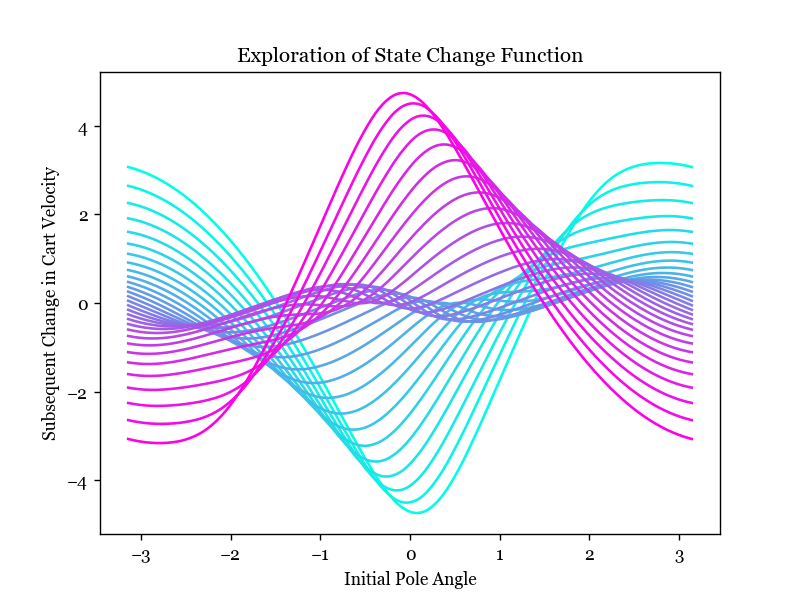

Text(0, 0.5, 'Subsequent Change in Cart Velocity')

In [12]:
fig, ax = plt.subplots(1, 1, num=9)  

# create array of interpolated colours 

col_lerp = np.linspace(0, 1, Nsteps)[np.newaxis].T
colours = ( 1 - col_lerp ) * np.array( [0, 255, 231, 255] )/255 + col_lerp * np.array( [255, 0, 230, 255] )/255


for i, row in enumerate(state_changes):
       
    # convert to arrays and extract certain components from vectors
    
    x = initial_states[i,:,2] # extract initial angular velocity
    y = state_changes[i,:,1] # extract change in cart velocity
    
    # code to smooth plot lines
    
    xnew = np.linspace( x.min(), x.max(), 300 ) 

    y_spline = scipy.interpolate.make_interp_spline(x, y, k=2)
    y_smooth = y_spline(xnew)
    
    # plot then move onto next line

    ax.plot( xnew, y_smooth, color=colours[i] ) 

ax.set_title( "Exploration of State Change Function" )
ax.set_xlabel( "Initial Pole Angle" )
ax.set_ylabel( "Subsequent Change in Cart Velocity" )

This is the same as the plot above but this time plotting change in cart velocity as a function of initial pole angle, varying  the initial angular velocity from -15 in cyan to +15 in magenta. It looks like a linear estimator of $Y$ from $X$ will perform poorly, but looking at the central, dense part of the graph above (which represents a small initial angular velocity) we can see the curvature of the lines are much smaller. Keeping in mind the truncated Taylor series approximation to a function for small deviations, there is some scope to use linear estimation especially for small deviations about an equilibrium.

<IPython.core.display.Javascript object>


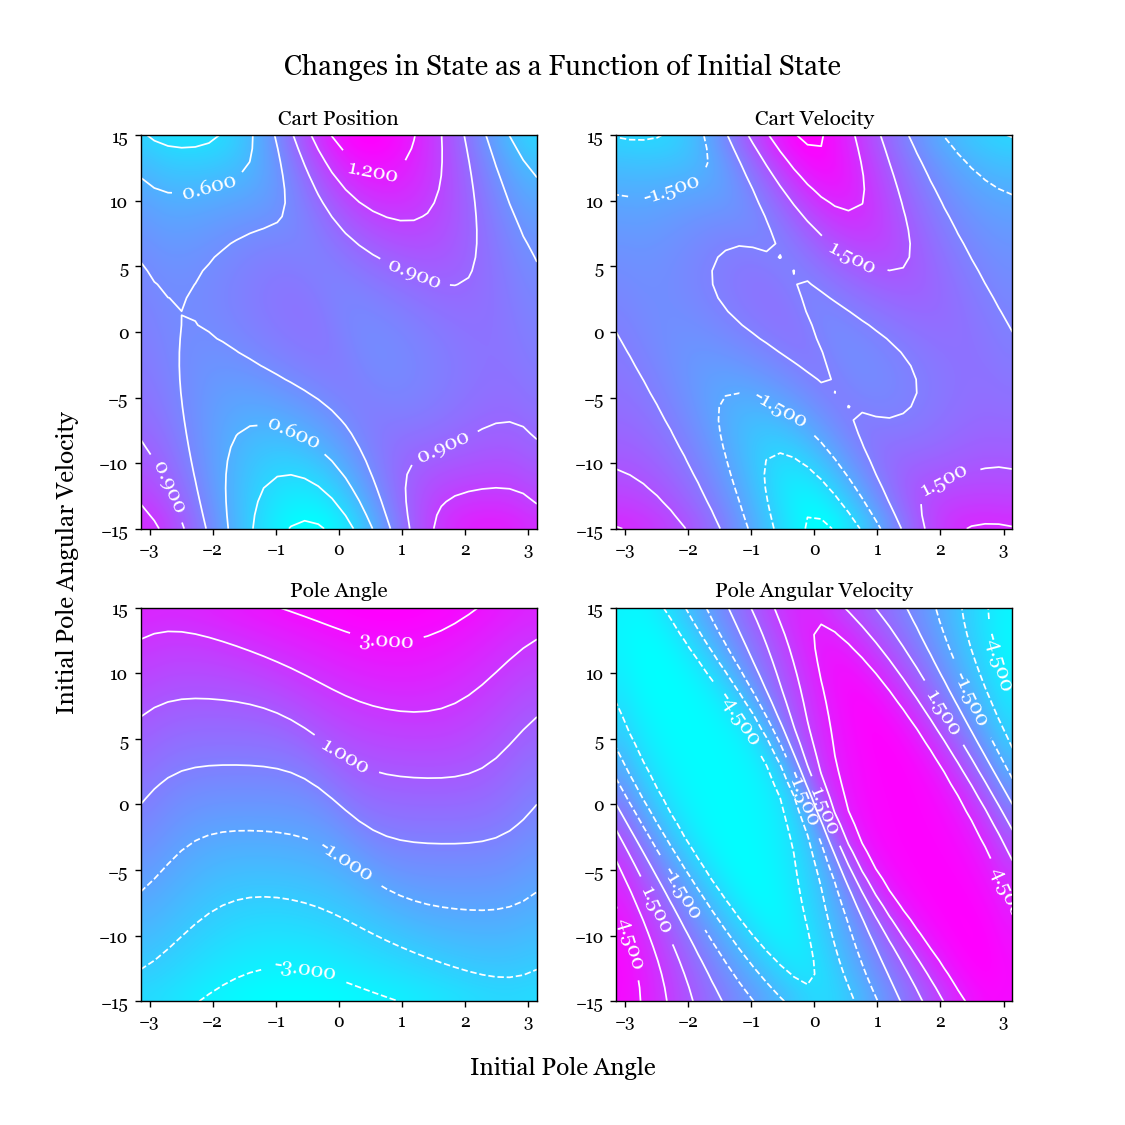

Text(0.06, 0.5, 'Initial Pole Angular Velocity')

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, num=11, figsize=(9,9))

titles = ["Cart Position", "Cart Velocity", "Pole Angle", "Pole Angular Velocity"]

for i, ax in enumerate( [ax1, ax2, ax3, ax4] ):

    ax.imshow( state_changes[:,:,i], interpolation="bicubic", extent=(-np.pi, np.pi, -15, 15), aspect='auto', cmap="cool", origin='lower' )
    contour = ax.contour( initial_states[0,:,2], initial_states[:,0,3], state_changes[:,:,i], colors="white", linewidths=1 )
    ax.clabel( contour, contour.levels[1::2], inline=True, fontsize=12 )    
    ax.set_title( titles[i] )
    
fig.text(0.5, 0.94, 'Changes in State as a Function of Initial State', ha='center', va='center', fontsize=16)
fig.text(0.5, 0.05, 'Initial Pole Angle', ha='center', va='center', fontsize=14)
fig.text(0.06, 0.5, 'Initial Pole Angular Velocity', ha='center', va='center', rotation='vertical', fontsize=14)


In the plot above I vary initial pole angle in the x direction and initial pole angular velocity in the y direction and show the changes in the state variables in the contour plots. It is quite hard to find linearity in the plots.

# Task 1.3: Linear Model

I assume that the change in state is a linear function of the current state:

$$
Y = f(X) = XC
$$

where $C$ is a 4x4 matrix. First I generate 500 input/output pairs by randomly generating 500 initial states and then performing 1 step (one call to `perform_action`) to generate 500 subsequent states.


## Generating Training Data

In [25]:
# set the random seed to make this cell deterministic
np.random.seed(4)

# generate random arrays of 500 values

random_positions  = np.random.rand( 500 ) * 10 - 5
random_velocities = np.random.rand( 500 ) * 20 - 10
random_angles     = np.random.rand( 500 ) * np.pi * 2 - np.pi
random_angvels    = np.random.rand( 500 ) * 30 - 15

# stack random values into 500 state vectors

X = initial_states = np.stack( [
    random_positions,
    random_velocities,
    random_angles,
    random_angvels
] ).T

Y = subsequent_states = np.array( [ CartPole.perform_action( state ) - state for state in initial_states ] )

## Finding the Least-Squares Fit

The Moore-Penrose pseudoinverse can then be used to construct the least-squares matrix that maps $X$ to $Y$:

$$
Y = XC
$$
$$
X^{+}Y = X^{+}XC = C
$$

In [26]:
Xplus = np.linalg.inv(X.T @ X) @ X.T
C = Xplus @ Y

cache["C_large_deviations"] = C

## Evaluating the Linear Estimator

We can now compare our linear model to the experimental data we plotted in task 1.2.

## Plotting Predicted State Change Against Target State Change

<IPython.core.display.Javascript object>


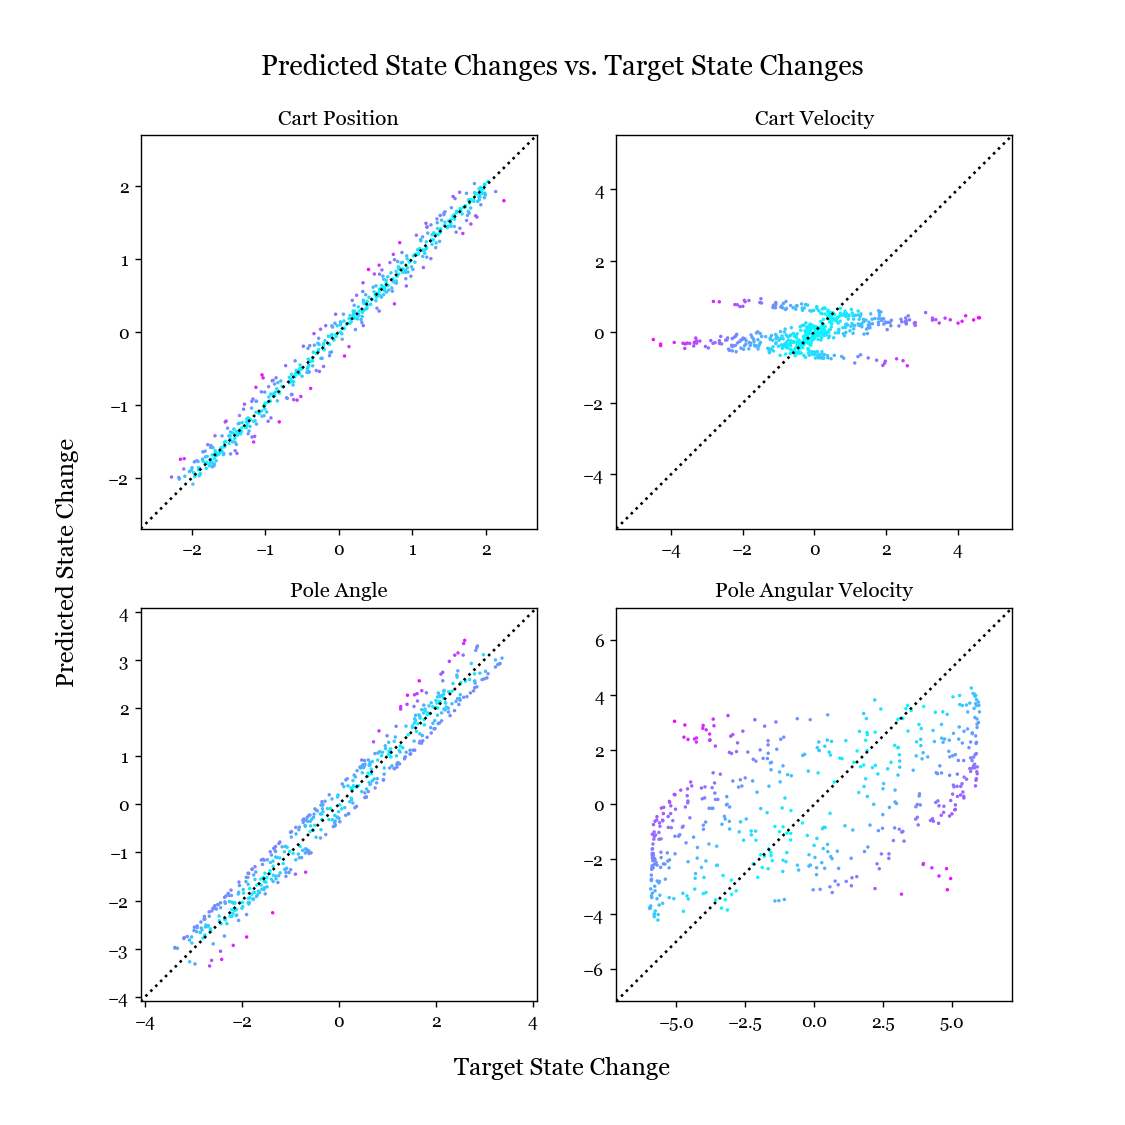

Text(0.06, 0.5, 'Predicted State Change')

In [16]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, num=19, figsize=(9,9))

XC = X @ C

titles = ["Cart Position", "Cart Velocity", "Pole Angle", "Pole Angular Velocity"]

for i, ax in enumerate( [ax1, ax2, ax3, ax4] ):
    
    x, y = (XC)[:,i], Y[:,i]
    c = np.abs(x - y)
    
    extent = np.max( ( np.concatenate([x, y]) ) ) * 1.2
    
    ax.scatter( y, x, s=1, c=c, cmap="cool" )
    ax.set_xlim(-extent, extent)
    ax.set_ylim(-extent, extent)
    
    ax.plot( [-extent, extent], [-extent, extent], color="black", linestyle="dotted" )
    
    ax.set_title( titles[i] )
    
fig.text(0.5, 0.94, 'Predicted State Changes vs. Target State Changes', ha='center', va='center', fontsize=16)
fig.text(0.5, 0.05, 'Target State Change', ha='center', va='center', fontsize=14)
fig.text(0.06, 0.5, 'Predicted State Change', ha='center', va='center', rotation='vertical', fontsize=14)
    

The plot above shows one dot per training data element, and I plotted one graph per element in the state change vector. For each dot, the x coordinate is the target change in state as returned from `perform_action` and the y coordinate is the predicted change as returned by the linear estimator. So for perfect predictions, these would be equal and the points would all lie on the line $y=x$ shown in dotted black.

It is clear that the changes in cart position and pole angle are well predicted by the linear estimator, with the points lying close to the ideal line. The change in cart velocity as least has the central mass of points lying near the ideal line, but with many outliers at the edges, while the change in pole angular velocity is very poorly explained by the linear model with the points avoiding the ideal line.

## Linear Model for Small Deflections Only

In the following cells I have repeated the above procedure, but limited the training data to small deflections from equilibrium (inital states between -0.25 and 0.25). Thinking back to the Taylor series approximation for a function I expected this scheme to yield better predictions near the equilibrium.

<IPython.core.display.Javascript object>


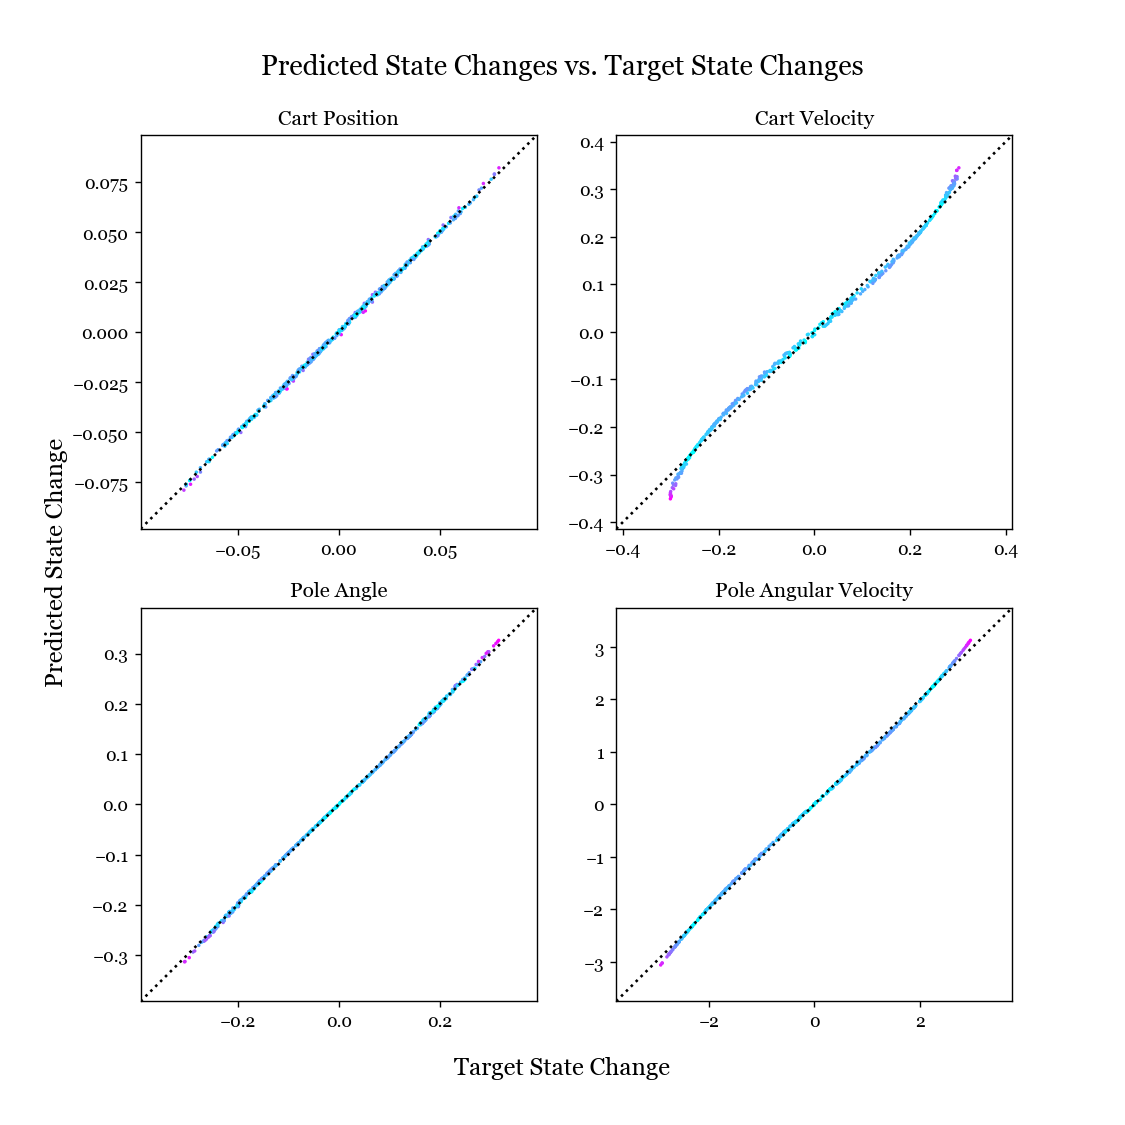

Text(0.05, 0.5, 'Predicted State Change')

In [17]:
# generate random arrays of 500 values

random_positions  = np.random.rand( 500 ) * 0.5 - 0.25
random_velocities = np.random.rand( 500 ) * 0.5 - 0.25
random_angles     = np.random.rand( 500 ) * 0.5 - 0.25
random_angvels    = np.random.rand( 500 ) * 0.5 - 0.25

# stack random values into 500 state vectors

X = initial_states = np.stack( [
    random_positions,
    random_velocities,
    random_angles,
    random_angvels
] ).T

Y = subsequent_states = np.array( [ CartPole.perform_action( state ) - state for state in initial_states ] )


Xplus = np.linalg.inv(X.T @ X) @ X.T
C = Xplus @ Y


fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, num=20, figsize=(9,9))

XC = X @ C

titles = ["Cart Position", "Cart Velocity", "Pole Angle", "Pole Angular Velocity"]

for i, ax in enumerate( [ax1, ax2, ax3, ax4] ):
    
    x, y = (XC)[:,i], Y[:,i]
    c = np.abs(x - y)
    
    extent = np.max( ( np.concatenate([x, y]) ) ) * 1.2
    
    ax.scatter( y, x, s=1, c=c, cmap="cool" )
    ax.set_xlim(-extent, extent)
    ax.set_ylim(-extent, extent)
    
    ax.plot( [-extent, extent], [-extent, extent], color="black", linestyle="dotted" )
    
    ax.set_title( titles[i] )
    
fig.text(0.5, 0.94, 'Predicted State Changes vs. Target State Changes', ha='center', va='center', fontsize=16)
fig.text(0.5, 0.05, 'Target State Change', ha='center', va='center', fontsize=14)
fig.text(0.05, 0.5, 'Predicted State Change', ha='center', va='center', rotation='vertical', fontsize=14)


It is clear that the linear model is working nicely for small deflections, with all the points near to the ideal lines. Perhaps we could build a good model by using many linear models centered around different points, which is the motivation behind moving to a nonlinear model.

## Comparing Prediction Contour Plots to Target Contour Plots

I generated 4 contour plots for the predicted state change of each the state vector elements as predicted by the linear model.   I am varying the initial pole angle and angular velocity again, so I am aiming for these contour plots to be identical to the final 4 I plotted in task 1.2. Note that we are back to using the linear estimate for large deviations.

In [18]:
C = cache["C_large_deviations"]

# sweep over different initial pole angles and angvels and find the predicted change in state

# number of steps to vary the intial conditions across their range
Nsteps = 30

# setup some intial conditions to loop over, varying the intial pole angle and angular velocity

initial_cart_positions  = np.array( [2] )
initial_cart_velocities = np.array( [4] )
initial_pole_angles     = np.linspace( -np.pi, np.pi, num=Nsteps )
initial_pole_angvels    = np.linspace( -15, 15, num=Nsteps )

# create array of initial state vectors

initial_states = np.array( np.meshgrid(
    initial_cart_positions, 
    initial_cart_velocities, 
    initial_pole_angles, 
    initial_pole_angvels 
)).T.squeeze()

# get 2d array of subsquent state vectors

predicted_changes = initial_states.reshape( (Nsteps**2,4) ) @ C
predicted_changes = predicted_changes.reshape( (Nsteps, Nsteps, 4) )

cache["linear_predicted_changes_varying_angle_and_angvel"] = predicted_changes

<IPython.core.display.Javascript object>


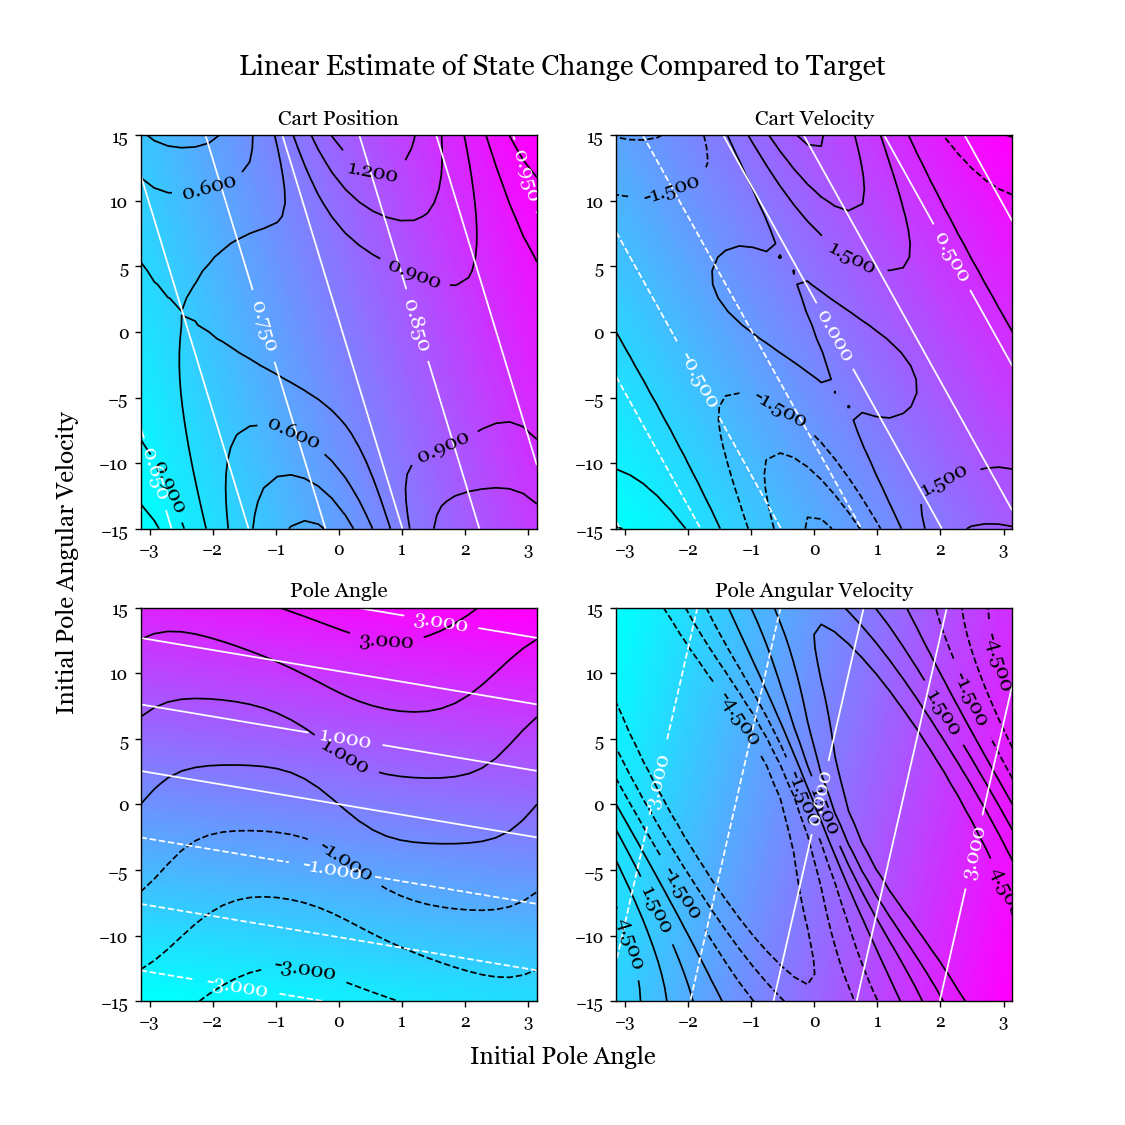

Text(0.06, 0.5, 'Initial Pole Angular Velocity')

In [19]:
state_changes = cache["state_changes_varying_angle_and_angvel"]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, num=15, figsize=(9,9))

titles = ["Cart Position", "Cart Velocity", "Pole Angle", "Pole Angular Velocity"]

for i, ax in enumerate( [ax1, ax2, ax3, ax4] ):

    ax.imshow( predicted_changes[:,:,i], interpolation="bicubic", extent=(-np.pi, np.pi, -15, 15), aspect='auto', cmap="cool", origin='lower' )
    target_contour = ax.contour( initial_states[0,:,2], initial_states[:,0,3], state_changes[:,:,i], colors="black", linewidths=1 )
    
    ax.clabel( target_contour, target_contour.levels[1::2], inline=True, fontsize=12 ) 
    estimate_contour = ax.contour( initial_states[0,:,2], initial_states[:,0,3], predicted_changes[:,:,i], colors="white", linewidths=1 )
    
    ax.clabel( estimate_contour, estimate_contour.levels[1::2], inline=True, fontsize=12 )    
    ax.set_title( titles[i] )
    
fig.text(0.5, 0.94, 'Linear Estimate of State Change Compared to Target', ha='center', va='center', fontsize=16)
fig.text(0.5, 0.06, 'Initial Pole Angle', ha='center', va='center', fontsize=14)
fig.text(0.06, 0.5, 'Initial Pole Angular Velocity', ha='center', va='center', rotation='vertical', fontsize=14)


The contours from the linear estimator are in white and the target contours are in black. Clearly the nonlinearities in the data have been discarded and the linear estimator has picked up on only the lowest-frequency linear trends. I would expect this model to miss most of the nuance in the motion of the cartpole, especially in the nonlinear rotational motion of the pole.

In [20]:
# sweep over different initial cart velocities and angles and find the subsequent change in state

# number of steps to vary the intial conditions across their range
Nsteps = 30

# setup some intial conditions to loop over, varying the intial cart velocity and pole angular velocity

initial_cart_positions  = np.array( [1] )
initial_cart_velocities = np.linspace( -10, 10, num=Nsteps )
initial_pole_angles     = np.array( [2] )
initial_pole_angvels    = np.linspace( -15, 15, num=Nsteps )

# create array of initial state vectors

initial_states = np.array( np.meshgrid( 
    initial_cart_positions, 
    initial_cart_velocities, 
    initial_pole_angles, 
    initial_pole_angvels 
)).T.squeeze()

# get 2d array of subsquent state vectors

state_changes = [ CartPole.perform_action( state ) - state for state in initial_states.reshape( (Nsteps**2,4) ) ]
state_changes = np.array( state_changes ).reshape( (Nsteps, Nsteps, 4) )

predicted_changes = initial_states.reshape( (Nsteps**2,4) ) @ C
predicted_changes = np.array( predicted_changes ).reshape( (Nsteps, Nsteps, 4) )

<IPython.core.display.Javascript object>


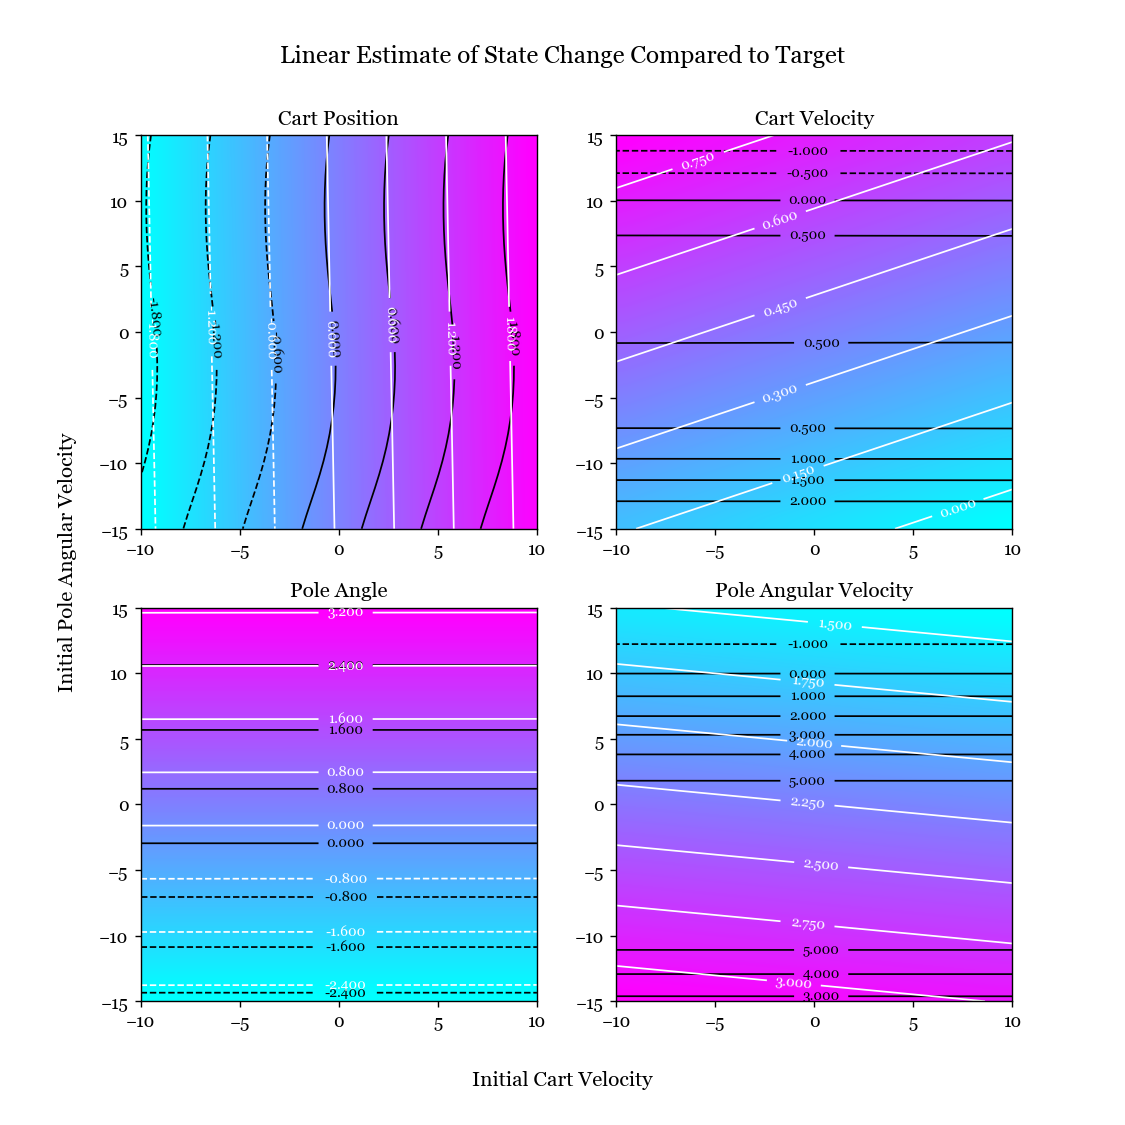

Text(0.06, 0.5, 'Initial Pole Angular Velocity')

In [21]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, num=16, figsize=(9,9))

titles = ["Cart Position", "Cart Velocity", "Pole Angle", "Pole Angular Velocity"]

for i, ax in enumerate( [ax1, ax2, ax3, ax4] ):

    ax.imshow( predicted_changes[:,:,i], interpolation="bicubic", extent=(-10, 10, -15, 15), aspect='auto', cmap="cool", origin='lower' )
    target_contour = ax.contour( initial_states[0,:,1], initial_states[:,0,3], state_changes[:,:,i], colors="black", linewidths=1 )
    
    ax.clabel( target_contour, inline=True, fontsize=8 ) 
    estimate_contour = ax.contour( initial_states[0,:,1], initial_states[:,0,3], predicted_changes[:,:,i], colors="white", linewidths=1 )
    
    ax.clabel( estimate_contour, inline=True, fontsize=8 )    
    ax.set_title( titles[i] )
    
fig.text(0.5, 0.95, 'Linear Estimate of State Change Compared to Target', ha='center', va='center', fontsize=14)
fig.text(0.5, 0.04, 'Initial Cart Velocity', ha='center', va='center', fontsize=12)
fig.text(0.06, 0.5, 'Initial Pole Angular Velocity', ha='center', va='center', rotation='vertical', fontsize=12)


However, the linear estimator works better when we plot contours while varying the initial cart velocity and pole angular velocity as above. This is the pair of variables I didn't plot contours for in task 1.2, but here we can see how the 2 trends on the left are closer to linear and the white and black contour lines are in close agreement. This is in agreement with the results from the scatter plots where the predictions for change in cart position and pole angle were much more accurate.

The elements that are well predicted by the linear model are the change in cart location and pole angle. The change in cart location will be quite similar to the velocity of the cart times the timestep (neglecting acceleration during the timestep), so it is expected that we could predict this as a linear function of the velocity. The change in pole angle is similar in that it will be quite similar to the angular velocity.

# Task 1.4: Prediction of System Evolution

Now the linear model can predict the system evolution by incrementing the current state by the prediction for the state change repeatedly. This can be used as an alterative to the analytic system dynamics, so I have reproduced the three plots from task 1.1 but now using the linear model rather than the actual dynamics.

It is vital to remap the pole angle to the range $-\pi$ to $\pi$ during this process. If this is not done, the angle grows beyond anything seen in the training data and the result is an abnormally large input of energy to the system which causes divergence.

## Small Oscillations

<IPython.core.display.Javascript object>


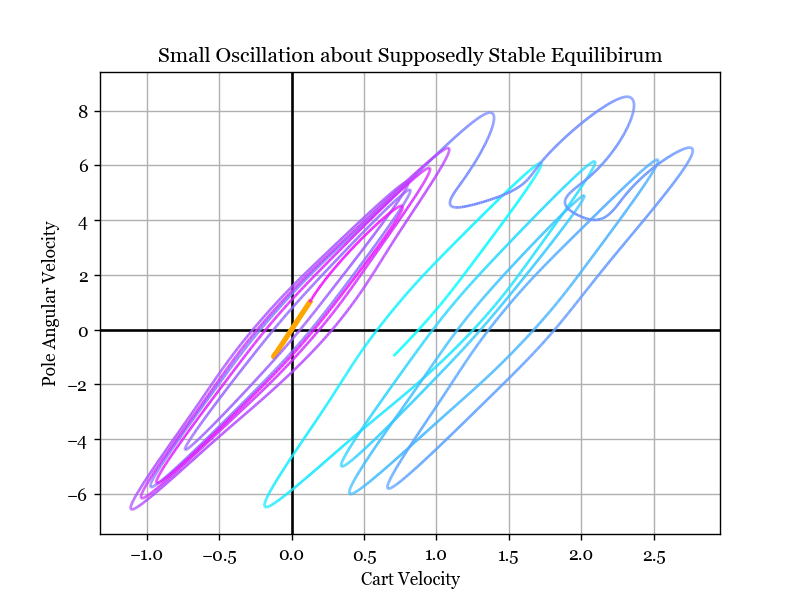

Text(0, 0.5, 'Pole Angular Velocity')

In [28]:
actual_states = cache["states_small_oscillations"]

fig, ax = plt.subplots(1, 1, num=22)
sf3utility.setup_phase_portrait( ax )

# small oscillations about stable equilibrium

state = np.array( [0, 0.126, np.pi, 1] )

prediction_states = []

for i in range(100):
    
    prediction_states.append( state )
    state = state @ ( C + np.identity(4) )
    state[2] = CartPole.remap_angle( state[2] )
    

prediction_states = np.array( prediction_states )
    
x = prediction_states[:,1]
y = prediction_states[:,3]

f, u = scipy.interpolate.splprep( [x, y], s=0, per=True )
xint, yint = scipy.interpolate.splev(np.linspace(0, 1, 10000), f)

centerx = (max(x) + min(x)) / 2
centery = (max(y) + min(y)) / 2

ax.set_xlim( centerx - (centerx - min(x)) * 1.12, centerx + (max(x) - centerx) * 1.12 )
ax.set_ylim( centery - (centery - min(y)) * 1.12, centery + (max(y) - centery) * 1.12 )

points   = np.array([xint, yint]).T.reshape(-1, 1, 2)[::-1]
segments = np.concatenate( [points[:-1], points[1:]], axis=1 )[500:]
colouring_array =  np.linspace( 0.0, 1.0, len(xint) )# ** 3

linecollection = matplotlib.collections.LineCollection( segments, array=colouring_array, cmap="cool", zorder=3 )

ax.add_collection( linecollection )

x = actual_states[:,1]
y = actual_states[:,3]

ax.plot( x, y, color="orange", linewidth=3 )

ax.set_title( "Small Oscillation about Supposedly Stable Equilibirum" )
ax.set_xlabel( "Cart Velocity" )
ax.set_ylabel( "Pole Angular Velocity" )

The plot above is initialised the same as the small oscillations case from the first plot in this report, and shows the time evolution of the pole angular velocity plotted against cart velocity. The target behaviour is shown in orange, which is the data from the small oscillation plot using the analytic dynamics. The linear estimation time evolution is the curve that starts in magenta at initialisation and turns more cyan as time goes on. 

The linear model successfully brings the system into an oscillating state, shown by the loops about the origin, although these oscillations are of much larger amplitude than they should be (the loops are larger than the orange line). After a few oscillations, the system spontaneously shifts into a regime where it is still oscillating but also moving to the right, shown by the loops shifted to the right. It's important to note that this is a particularly lucky result based on favourable random generation of training data - most plots I made with other training data diverged from the oscillating regime in fewer time steps. The random increase in kinetic energy indicate that conservation of energy is a nonlinear detail in the data that the linear model struggles to capture.

<IPython.core.display.Javascript object>


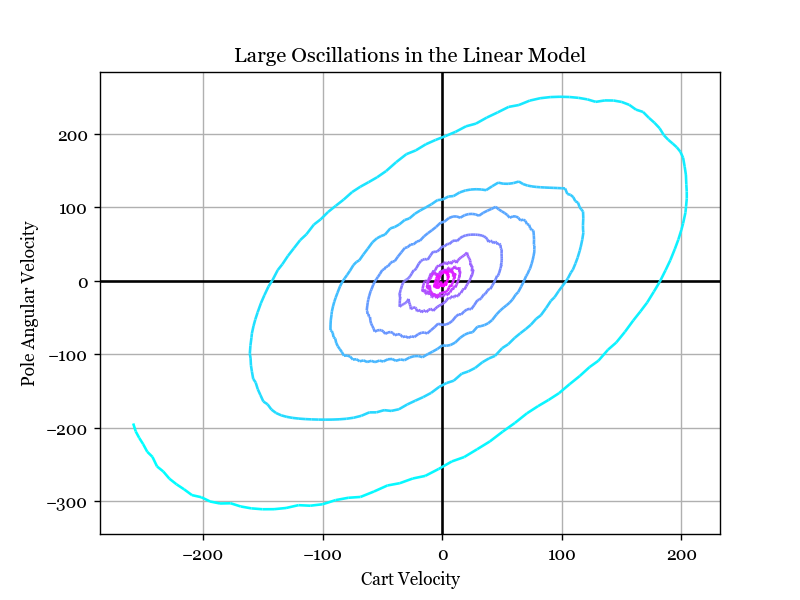

In [32]:
actual_states = cache["states_large_oscillations"]

# large oscillations about stable equilibrium

state = np.array( [0, 1.72, np.pi, 10] )

x, y = [], []

for i in range(1000):
    
    x.append( state[1] )
    y.append( state[3] )
    
    state += state @ C
    state[2] = CartPole.remap_angle( state[2] )
    
    
fig, ax = plt.subplots(1, 1, num=23)
sf3utility.setup_phase_portrait( ax )

centerx = (max(x) + min(x)) / 2
centery = (max(y) + min(y)) / 2

ax.set_xlim( centerx - (centerx - min(x)) * 1.12, centerx + (max(x) - centerx) * 1.12 )
ax.set_ylim( centery - (centery - min(y)) * 1.12, centery + (max(y) - centery) * 1.12 )

points   = np.array([x, y]).T.reshape(-1, 1, 2)[::-1]
segments = np.concatenate( [points[:-1], points[1:]], axis=1 )
colouring_array =  np.linspace( 0.0, 1.0, len(x) )

linecollection = matplotlib.collections.LineCollection( segments, array=colouring_array, cmap="cool", zorder=3 )

ax.add_collection( linecollection )

ax.set_title( "Large Oscillations in the Linear Model" )
ax.set_xlabel( "Cart Velocity" )
ax.set_ylabel( "Pole Angular Velocity" )

states = np.array( states )

The plot above is the same as the previous one, but starting with a larger pole angular velocity so that the oscillations are larger. Again as time progresses the line goes from magenta to cyan, and we can see that both the pole angular velocity and cart velocity are increasing. The outward spiral is indicative of an unstable system; again the linear model can't enforce conservation of energy. However, the spiral structure does indicate that the model has some understanding that a larger cart velocity implies a smaller pole angular velocity.

In [24]:
# even larger oscillations

rollout_cartpole.reset()

state = np.array( [0, 4, 0, 20] )
    
x, y = [], []

for i in range( 300 ):
    
    pole_angle = state[2] % (2*np.pi)
    
  
    x.append( pole_angle )
    y.append( state[3] )
    
    state += state @ C
    state[2] = CartPole.remap_angle( state[2] )
    
    
fig, ax = plt.subplots(1, 1, num=24)
sf3utility.setup_phase_portrait( ax )
ax.axvline( x=np.pi, color="black" )

ax.set_xlim( min(x) * 1.12, max(x) * 1.12 )
ax.set_ylim( min(y) * 1.12, max(y) * 1.12 )

points   = np.array([x, y]).T.reshape(-1, 1, 2)[::-1]
segments = np.concatenate( [points[:-1], points[1:]], axis=1 )
colouring_array =  np.linspace( 0.0, 1.0, len(x) ) ** 3

linecollection = matplotlib.collections.LineCollection( segments, array=colouring_array, cmap="cool", zorder=3 )

ax.add_collection( linecollection )

ax.set_xlim(0.2, 6)
ax.set_xticks( np.pi * np.array([0.5, 1, 1.5]) )
ax.set_xticklabels( ["π/2", "π", "3π/2"] )

ax.set_title( "Phase Plot with Complete Rotations" )
ax.set_xlabel( "Pole Angle" )
ax.set_ylabel( "Pole Angular Velocity" )

UFuncTypeError: Cannot cast ufunc 'add' output from dtype('float64') to dtype('int32') with casting rule 'same_kind'

This final plot has the pole angular velocity plotted against the pole angle as the system evolves. The smooth phase space from task 1.1 has been replaced by incoherent jagged lines which don't reflect the motion of the cartpole. This was to be expected because in the scatter plots that showed prediction accuracy, the pole angular velocity was the least well-explained by the linear model. So especially at the large angular velocities in this case, where nonlinear effects dominate, the linear model is incapable of explaining the data.

## Improved Angle Definition

In [ ]:
# set the random seed to make this cell deterministic
np.random.seed(4)

# generate random arrays of 500 values

random_positions  = np.random.rand( 500 ) * 10 - 5
random_velocities = np.random.rand( 500 ) * 20 - 10
random_angles     = np.random.rand( 500 ) * np.pi * 2 - np.pi
random_angvels    = np.random.rand( 500 ) * 30 - 15

# stack random values into 500 state vectors

X = initial_states = np.stack( [
    random_positions,
    random_velocities,
    random_angles,
    random_angvels
] ).T

Y = subsequent_states = np.array( [ CartPole.perform_action( state, better_angle = True ) - state for state in initial_states ] )